In [22]:
import numpy as np
from scipy.stats import pearsonr, spearmanr, wasserstein_distance
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from itertools import combinations


def uniform_heatmaps(hatmap_array, height=224, width=224, num_images=None):
    """Uniform the heatmaps HxW to match a given height and width,
    optionally processing only a subset of images.
    Ensures that the output heatmaps are normalized to the [0, 1] range."""
    if hatmap_array.ndim != 3:
        raise ValueError("Input heatmap array must be 3D (B, height, width)")

    # If num_images is specified, slice the array to take only the first num_images
    if num_images is not None:
        if not isinstance(num_images, int) or num_images <= 0:
            raise ValueError("num_images must be a positive integer.")
        if num_images > hatmap_array.shape[0]:
            raise ValueError(f"num_images ({num_images}) cannot be greater than the number of available images ({hatmap_array.shape[0]}).")
        hatmap_array = hatmap_array[:num_images]

    n_batch, h_orig, w_orig = hatmap_array.shape

    # Create the final output array with float type for normalized values
    final_normalized_heatmaps = np.zeros((n_batch, height, width), dtype=np.float32)

    for i in range(n_batch):
        current_heatmap_slice = hatmap_array[i]

        # Step 1: Resize if necessary
        if h_orig == height and w_orig == width:
            # No resize needed
            processed_heatmap = current_heatmap_slice
        else:
            # Resize needed
            # cv2.resize expects dsize as (width, height)
            processed_heatmap = cv2.resize(current_heatmap_slice, (width, height), interpolation=cv2.INTER_LINEAR)
            # processed_heatmap now has shape (height, width)

        # Step 2: Normalize the processed_heatmap to [0, 1] range
        min_val = processed_heatmap.min()
        max_val = processed_heatmap.max()

        if max_val > min_val:
            # Perform normalization. Ensure float arithmetic.
            final_normalized_heatmaps[i] = (processed_heatmap.astype(np.float32) - min_val) / (max_val - min_val)
        else:
            # Constant heatmap (max_val == min_val).
            # Map to all zeros. This ensures min is 0 (and max is also 0).
            final_normalized_heatmaps[i] = np.zeros((height, width), dtype=np.float32)
            
    return final_normalized_heatmaps
           

def compare_heatmaps(heatmap_arrays, metrics=['mse', 'correlation', 'cosine', 'ssim', 'emd'],model_names=None):
    """
    Compare similarity between multiple heatmap arrays.
    
    Args:
        heatmap_arrays: List of numpy arrays, each with shape (n_images, height, width)
        metrics: List of metrics to compute ('mse', 'correlation', 'cosine', 'ssim', 'emd')
        model_names: Optional list of model names for labeling the results in the dictionary
        
    Returns:
        Dictionary containing results for each metric and each pair of arrays
    """
    n_arrays = len(heatmap_arrays)
    n_images = heatmap_arrays[0].shape[0]
    
    # Validate input shapes
    for i, arr in enumerate(heatmap_arrays):
        print(f"Array {i} shape: {arr.shape}")
        if arr.shape != heatmap_arrays[0].shape:
            raise ValueError(f"Array {i} has shape {arr.shape}, expected {heatmap_arrays[0].shape}")
    
    # Initialize results dictionary
    results = {metric: {} for metric in metrics}
    
    # Generate all pairs of arrays to compare
    array_pairs = list(combinations(range(n_arrays), 2))
    
    # For each pair of arrays
    for (i, j) in array_pairs:
        pair_key = f"{i}_vs_{j}"
        
        # Initialize per-image results
        if 'mse' in metrics:
            results['mse'][pair_key] = np.zeros(n_images)
        if 'correlation' in metrics:
            results['correlation'][pair_key] = np.zeros(n_images)
        if 'cosine' in metrics:
            results['cosine'][pair_key] = np.zeros(n_images)
        if 'ssim' in metrics:
            results['ssim'][pair_key] = np.zeros(n_images)
        if 'emd' in metrics:
            results['emd'][pair_key] = np.zeros(n_images)
        
        # Compute metrics for each image pair
        for img_idx in range(n_images):
            heatmap1 = heatmap_arrays[i][img_idx]
            heatmap2 = heatmap_arrays[j][img_idx]
            
            # Flatten arrays for some metrics
            flat1 = heatmap1.flatten()
            flat2 = heatmap2.flatten()
            
            # Calculate metrics
            if 'mse' in metrics:
                results['mse'][pair_key][img_idx] = mean_squared_error(flat1, flat2)
            
            if 'correlation' in metrics:
                # Pearson correlation
                results['correlation'][pair_key][img_idx] = pearsonr(flat1, flat2)[0]
            
            if 'cosine' in metrics:
                # Reshape for cosine similarity
                results['cosine'][pair_key][img_idx] = cosine_similarity(
                    flat1.reshape(1, -1), flat2.reshape(1, -1)
                )[0][0]
            
            if 'ssim' in metrics:
                # Structural similarity
                # Ensure data range is appropriate, especially if heatmaps are normalized
                min_val = min(heatmap1.min(), heatmap2.min())
                max_val = max(heatmap1.max(), heatmap2.max())
                data_range = max_val - min_val if max_val > min_val else 1.0 # Avoid division by zero
                results['ssim'][pair_key][img_idx] = ssim(
                    heatmap1, heatmap2, data_range=data_range
                )
            
            if 'emd' in metrics:
                # Earth Mover's Distance (Wasserstein distance)
                results['emd'][pair_key][img_idx] = wasserstein_distance(flat1, flat2)
            
    
    # Compute summary statistics
    summary = {metric: {} for metric in metrics}
    for metric in metrics:
        for pair_key in results[metric]:
            summary[metric][pair_key] = {
                'mean': np.mean(results[metric][pair_key]),
                'std': np.std(results[metric][pair_key]),
                'min': np.min(results[metric][pair_key]),
                'max': np.max(results[metric][pair_key]),
                'median': np.median(results[metric][pair_key])
            }
    
    return {'per_image': results, 'summary': summary}

def visualize_similarity_matrix(results, model_names, metric='cosine', stat='mean',
                               figsize=(12, 8), cmap='coolwarm', annotate=True,
                               plot_upper_triangle=False): # If True, will now plot LOWER triangle
    """
    Visualize similarity matrix between models.
    If plot_upper_triangle is True, it will display the LOWER triangle.
    Color scales are automatically fixed based on the metric.
    """
    if metric not in results['summary']:
        raise ValueError(f"Metric '{metric}' not found in results. Available metrics: {list(results['summary'].keys())}")

    n_models = len(model_names)
    similarity_matrix = np.zeros((n_models, n_models))

    for i in range(n_models):
        if metric == 'mse' or metric == 'emd':
            similarity_matrix[i, i] = 0.0
        else:
            similarity_matrix[i, i] = 1.0

    for pair, metrics_data in results['summary'][metric].items():
        model_indices = pair.split('_vs_')
        if len(model_indices) == 2 and model_indices[0].isdigit() and model_indices[1].isdigit():
            i, j = map(int, model_indices)
            if i < n_models and j < n_models:
                similarity_matrix[i, j] = metrics_data[stat]
                similarity_matrix[j, i] = metrics_data[stat]
            else:
                print(f"Warning: Model indices {i}, {j} from pair '{pair}' are out of bounds. Skipping.")
        else:
            print(f"Warning: Could not parse indices from pair '{pair}'. Skipping.")

    plt.figure(figsize=figsize)
    current_cmap = cmap
    custom_vmin, custom_vmax = None, None
    cbar_label = ""

    if metric in ['cosine', 'correlation', 'ssim']:
        custom_vmin, custom_vmax = -1.0, 1.0
        cbar_label = f"{metric.capitalize()} Similarity"
        if cmap == 'coolwarm_r': current_cmap = 'coolwarm'
    elif metric == 'mse':
        custom_vmin = 0.0
        if cmap == 'coolwarm': current_cmap = 'coolwarm_r'
        cbar_label = "Mean Squared Error"
    elif metric == 'emd':
        custom_vmin = 0.0
        if cmap == 'coolwarm': current_cmap = 'coolwarm_r'
        cbar_label = "Earth Mover's Distance (Wasserstein)"
    else:
        cbar_label = f"{metric.capitalize()} {stat.capitalize()}"

    mask = None
    if plot_upper_triangle: # Parameter now implies plotting ONLY ONE triangle
        # To plot the LOWER triangle, we mask the UPPER triangle.
        # k=1 means exclude the diagonal from the mask.
        mask = np.triu(np.ones_like(similarity_matrix, dtype=bool), k=1)

    ax = sns.heatmap(
        similarity_matrix,
        annot=annotate,
        fmt=".2f",
        cmap=current_cmap,
        xticklabels=model_names,
        yticklabels=model_names,
        cbar_kws={"label": cbar_label},
        mask=mask,
        vmin=custom_vmin,
        vmax=custom_vmax
    )
    title_metric_name = metric.upper() if metric in ['mse', 'emd'] else metric.capitalize()
    plt.title(f"{title_metric_name} {stat.capitalize()} Between Heatmaps of Different Models")
    plt.tight_layout()
    return plt.gcf()

In [23]:
# Set BarlowTwins masking heatmaps directory
BARLOWTWINS_BASE_MASK_HEATMAPS_DIR = 'BarlowTwins/5_imgs_masking_experiment_outputs/Baseline_Model/numpy_saliency_maps/batch_maps.npy'
BARLOWTWINS_PRUNED_MASK_HEATMAPS_DIR = 'BarlowTwins/5_imgs_masking_experiment_outputs/Pruned_Model/numpy_saliency_maps/batch_maps.npy'

# Set DenseNet-161 masking heatmaps directory
DENSENET161_BASE_MASK_HEATMAPS_DIR = 'DenseNet-161/5_imgs_masking_experiment_outputs/Baseline_Model/numpy_saliency_maps/batch_maps.npy'
DENSENET161_PRUNED_MASK_HEATMAPS_DIR = 'DenseNet-161/5_imgs_masking_experiment_outputs/Pruned_Model/numpy_saliency_maps/batch_maps.npy'

# Set EfficientNet-B3 masking heatmaps directory
EFFICIENTNETB3_BASE_MASK_HEATMAPS_DIR = 'EfficientNet-B3/5_imgs_masking_experiment_outputs/Baseline_Model/numpy_saliency_maps/batch_maps.npy'
EFFICIENTNETB3_PRUNED_MASK_HEATMAPS_DIR = 'EfficientNet-B3/5_imgs_masking_experiment_outputs/Pruned_Model/numpy_saliency_maps/batch_maps.npy'

# Set ResNet-152 masking heatmaps directory
RESNET152_BASE_MASK_HEATMAPS_DIR = 'ResNet-152/5_imgs_masking_experiment_outputs/Baseline_Model/numpy_saliency_maps/batch_maps.npy'
RESNET152_PRUNED_MASK_HEATMAPS_DIR = 'ResNet-152/5_imgs_masking_experiment_outputs/Pruned_Model/numpy_saliency_maps/batch_maps.npy'

# Set VGG-16 masking heatmaps directory
VGG16_BASE_MASK_HEATMAPS_DIR = 'VGG16/dual_scores/5_imgs_masking_experiment_outputs/Baseline_Model/numpy_saliency_maps/batch_maps.npy'
VGG16_PRUNED_MASK_HEATMAPS_DIR = 'VGG16/dual_scores/5_imgs_masking_experiment_outputs/Pruned_Model/numpy_saliency_maps/batch_maps.npy'

# Set VGG-19 masking heatmaps directory
VGG19_BASE_MASK_HEATMAPS_DIR = 'VGG19/5_imgs_masking_experiment_outputs/Baseline_Model/numpy_saliency_maps/batch_maps.npy'
VGG19_PRUNED_MASK_HEATMAPS_DIR = 'VGG19/5_imgs_masking_experiment_outputs/Pruned_Model/numpy_saliency_maps/batch_maps.npy'


# Load the heatmaps
barlowtwins_base_mask_heatmaps = np.load(BARLOWTWINS_BASE_MASK_HEATMAPS_DIR)
barlowtwins_pruned_mask_heatmaps = np.load(BARLOWTWINS_PRUNED_MASK_HEATMAPS_DIR)
densenet161_base_mask_heatmaps = np.load(DENSENET161_BASE_MASK_HEATMAPS_DIR)
densenet161_pruned_mask_heatmaps = np.load(DENSENET161_PRUNED_MASK_HEATMAPS_DIR)
efficientnetb3_base_mask_heatmaps = np.load(EFFICIENTNETB3_BASE_MASK_HEATMAPS_DIR)
efficientnetb3_pruned_mask_heatmaps = np.load(EFFICIENTNETB3_PRUNED_MASK_HEATMAPS_DIR)
resnet152_base_mask_heatmaps = np.load(RESNET152_BASE_MASK_HEATMAPS_DIR)
resnet152_pruned_mask_heatmaps = np.load(RESNET152_PRUNED_MASK_HEATMAPS_DIR)
vgg16_base_mask_heatmaps = np.load(VGG16_BASE_MASK_HEATMAPS_DIR)
vgg16_pruned_mask_heatmaps = np.load(VGG16_PRUNED_MASK_HEATMAPS_DIR)
vgg19_base_mask_heatmaps = np.load(VGG19_BASE_MASK_HEATMAPS_DIR)
vgg19_pruned_mask_heatmaps = np.load(VGG19_PRUNED_MASK_HEATMAPS_DIR)



In [24]:
heatmaps = [
    barlowtwins_base_mask_heatmaps,
    barlowtwins_pruned_mask_heatmaps,
    densenet161_base_mask_heatmaps,
    densenet161_pruned_mask_heatmaps,
    efficientnetb3_base_mask_heatmaps,
    efficientnetb3_pruned_mask_heatmaps,
    resnet152_base_mask_heatmaps,
    resnet152_pruned_mask_heatmaps,
    vgg16_base_mask_heatmaps,
    vgg16_pruned_mask_heatmaps,
    vgg19_base_mask_heatmaps,
    vgg19_pruned_mask_heatmaps
]



model_names = [
    'BarlowTwins Baseline',
    'BarlowTwins Pruned',
    'DenseNet-161 Baseline',
    'DenseNet-161 Pruned',
    'EfficientNet-B3 Baseline',
    'EfficientNet-B3 Pruned',
    'ResNet-152 Baseline',
    'ResNet-152 Pruned',
    'VGG-16 Baseline',
    'VGG-16 Pruned',
    'VGG-19 Baseline',
    'VGG-19 Pruned'
]



# Uniform the heatmaps to a common size (224x224)
uniformed_heatmaps = []
target_height, target_width = 224, 224
for i, hm in enumerate(heatmaps):
    uniformed_heatmaps.append(uniform_heatmaps(hm, height=target_height, width=target_width, num_images=5))
    print(f"Processed {model_names[i]}: New shape {uniformed_heatmaps[-1].shape}")

    
# Compare using all available metrics including EMD
heatmaps_results = compare_heatmaps(uniformed_heatmaps, metrics=['cosine', 'correlation', 'ssim', 'mse', 'emd'] )



Processed BarlowTwins Baseline: New shape (5, 224, 224)
Processed BarlowTwins Pruned: New shape (5, 224, 224)
Processed DenseNet-161 Baseline: New shape (5, 224, 224)
Processed DenseNet-161 Pruned: New shape (5, 224, 224)
Processed EfficientNet-B3 Baseline: New shape (5, 224, 224)
Processed EfficientNet-B3 Pruned: New shape (5, 224, 224)
Processed ResNet-152 Baseline: New shape (5, 224, 224)
Processed ResNet-152 Pruned: New shape (5, 224, 224)
Processed VGG-16 Baseline: New shape (5, 224, 224)
Processed VGG-16 Pruned: New shape (5, 224, 224)
Processed VGG-19 Baseline: New shape (5, 224, 224)
Processed VGG-19 Pruned: New shape (5, 224, 224)
Array 0 shape: (5, 224, 224)
Array 1 shape: (5, 224, 224)
Array 2 shape: (5, 224, 224)
Array 3 shape: (5, 224, 224)
Array 4 shape: (5, 224, 224)
Array 5 shape: (5, 224, 224)
Array 6 shape: (5, 224, 224)
Array 7 shape: (5, 224, 224)
Array 8 shape: (5, 224, 224)
Array 9 shape: (5, 224, 224)
Array 10 shape: (5, 224, 224)
Array 11 shape: (5, 224, 224)


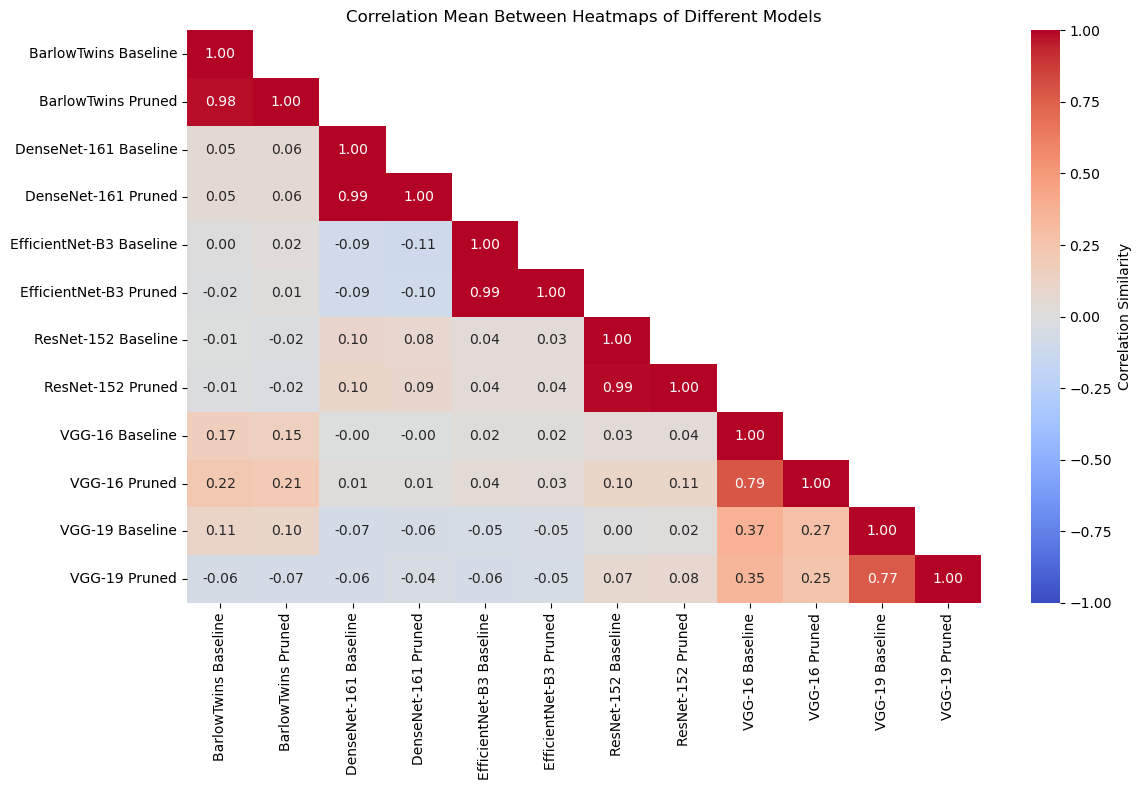

In [25]:
visualize_similarity_matrix(heatmaps_results, model_names, metric='correlation', stat='mean',plot_upper_triangle=True)

plt.show()
